In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define a broader list of tickers
tickers = ['LLY', 'XOM', 'TSLA', 'NVDA', 'CVX']

# Define the period for calculating percent change
start_date = "2021-01-01"
end_date = "2023-11-01"

all_data = {}  # Dictionary to store data for all tickers
percent_changes = {}

# Download historical stock data for each ticker
for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not stock_data.empty:
        percent_change = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0]
        percent_changes[ticker] = percent_change
        all_data[ticker] = stock_data  # Store the data

# Sort tickers based on percent change
top_5_tickers = sorted(percent_changes, key=percent_changes.get, reverse=True)[:5]

def rule_based_strategy(stock_data_dict, initial_balance=10000.0, trade_cost=1.00):
    indices = {ticker: 0 for ticker in stock_data_dict.keys()}
    done = False
    balances = {ticker: initial_balance for ticker in stock_data_dict.keys()}
    holdings = {ticker: 0 for ticker in stock_data_dict.keys()}
    trade_count = {ticker: 0 for ticker in stock_data_dict.keys()}  # Initialize trade count
    cumulative_profits = {ticker: [] for ticker in stock_data_dict.keys()}  # Initialize cumulative profits

    while not done:
        done = True  # Assume done unless a trade occurs
        actions = {ticker: 0 for ticker in stock_data_dict.keys()}  # Initialize actions as "hold" for all stocks

        for ticker in top_5_tickers:
            current_index = indices[ticker]
            if current_index >= len(stock_data_dict[ticker]) - 1:
                continue  # Skip if no more data for this ticker

            current_row = stock_data_dict[ticker].iloc[current_index]
            # Define the rule for buy/sell here based on your criteria (e.g., 5-day percent change)
            # Example rule (you should define your own logic here):
            if current_index >= 5:  # Check if at least 5 days of data available
                price_5_days_ago = stock_data_dict[ticker]['Close'].iloc[current_index - 5]
                current_price = current_row['Close']
                percent_change_5_days = (current_price - price_5_days_ago) / price_5_days_ago
                if percent_change_5_days > 0:
                    actions[ticker] = 2  # Buy
                elif percent_change_5_days < 0:
                    actions[ticker] = 1  # Sell

            # Execute buy or sell actions based on rule-based decisions
            if actions[ticker] == 1 and holdings[ticker] > 0:  # Sell
                shares_sold = holdings[ticker]
                revenue = shares_sold * current_row['Close']
                holdings[ticker] = 0
                balances[ticker] += revenue - trade_cost
                trade_count[ticker] += 1
            elif actions[ticker] == 2 and balances[ticker] > trade_cost:  # Buy
                max_shares_to_buy = int((balances[ticker] - trade_cost) / current_row['Close'])
                if max_shares_to_buy > 0:
                    shares_bought = max_shares_to_buy
                    cost = shares_bought * current_row['Close']
                    holdings[ticker] += shares_bought
                    balances[ticker] -= cost + trade_cost
                    trade_count[ticker] += 1

            indices[ticker] += 1
            if current_index < len(stock_data_dict[ticker]) - 1:
                done = False

            # Calculate and append cumulative profit for each ticker
            profit = balances[ticker] + (holdings[ticker] * stock_data_dict[ticker]['Close'].iloc[current_index]) - initial_balance
            cumulative_profits[ticker].append(profit)

    return cumulative_profits, trade_count

# Use the rule-based strategy to trade the top 5 stocks
cumulative_profits, trade_count = rule_based_strategy(all_data)



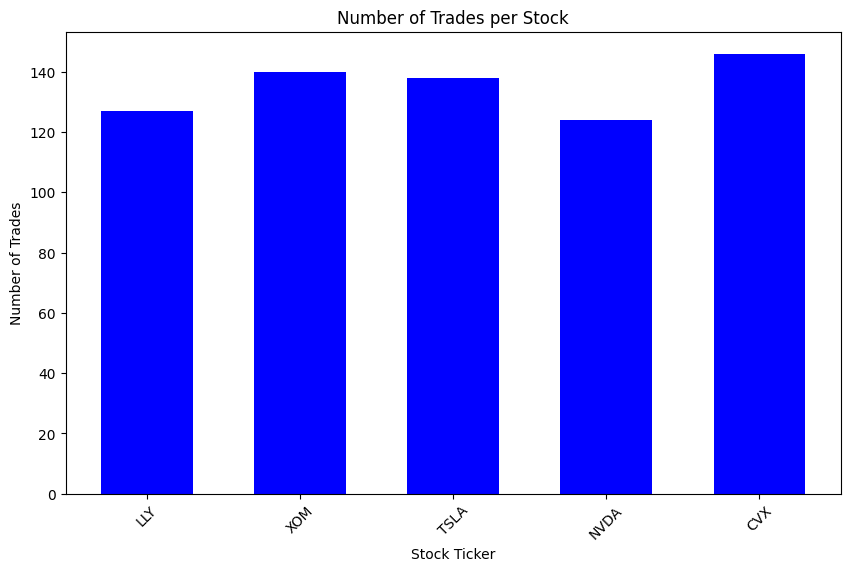

In [ ]:
# Plotting Number of Trades with Adjusted Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(trade_count.keys(), trade_count.values(), color='blue', width=0.6)  # Adjusted bar width
plt.title('Number of Trades per Stock')
plt.xlabel('Stock Ticker')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


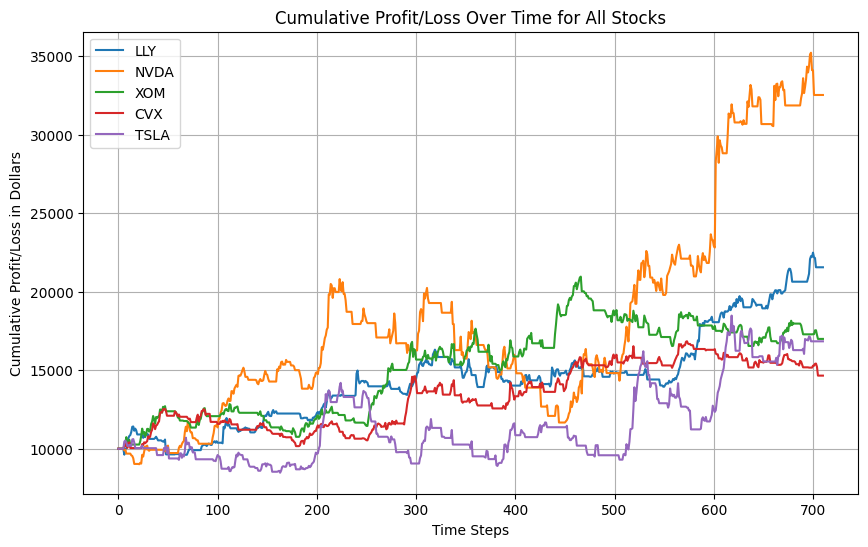

In [ ]:
initial_balance = 10000.0  # Initial balance for each stock

# Plotting Cumulative Profits for All Stocks Starting from Initial Balance
plt.figure(figsize=(10, 6))
for ticker in top_5_tickers:
    # Adding initial balance to each point in the cumulative profits
    adjusted_cumulative_profits = [profit + initial_balance for profit in cumulative_profits[ticker]]
    plt.plot(adjusted_cumulative_profits, label=f'{ticker}')

plt.title('Cumulative Profit/Loss Over Time for All Stocks')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Profit/Loss in Dollars')
plt.legend()
plt.grid(True)
plt.show()


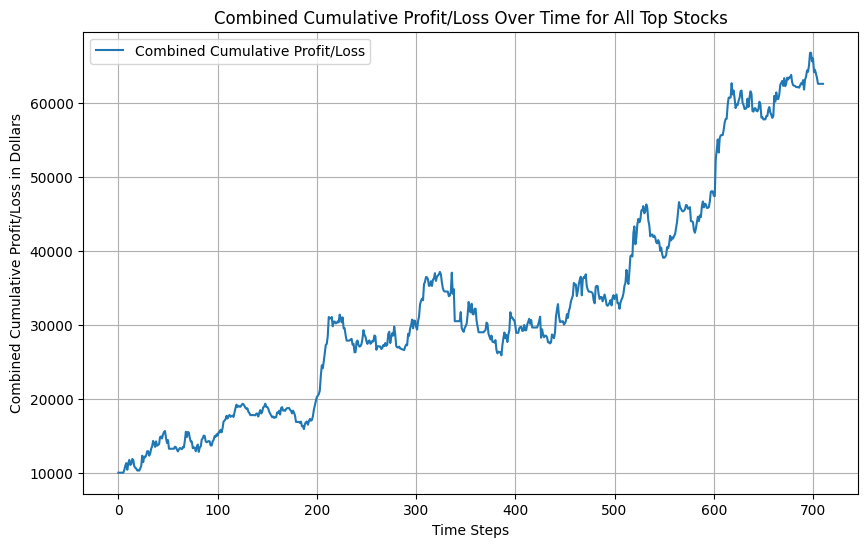

In [ ]:
# Determine the length of the shortest time series among the top stocks
min_length = min(len(cumulative_profits[ticker]) for ticker in top_5_tickers)

# Initialize a list to hold the combined cumulative profits
combined_cumulative_profits = [0] * min_length

# Add up the cumulative profits for each stock at each time step
for ticker in top_5_tickers:
    for i in range(min_length):
        combined_cumulative_profits[i] += cumulative_profits[ticker][i]

# Add the total initial balance to the combined cumulative profits
total_initial_balance = 10000.0  # Total initial balance for all stocks combined
combined_cumulative_profits = [profit + total_initial_balance for profit in combined_cumulative_profits]

# Plotting the combined cumulative profits
plt.figure(figsize=(10, 6))
plt.plot(combined_cumulative_profits, label='Combined Cumulative Profit/Loss')

plt.title('Combined Cumulative Profit/Loss Over Time for All Top Stocks')
plt.xlabel('Time Steps')
plt.ylabel('Combined Cumulative Profit/Loss in Dollars')
plt.legend()
plt.grid(True)
plt.show()
